# Preparation

We need to start with a density field. We are going to use FastPM code, which is DM only code that allows to quickly generate a DM density realization. See ... for the details.

## Installing components

You need to preinstall the following components.

* FastPM, nbodykit

The easiest (and probably the only proper way) is to install them through anaconda. If you are not familiar with anaconda -- it is a convenient tool for creating virtual Python environments. It simplifies installation of packages (instead of pip or easy_install).

See detailed instructions [here](https://github.com/rainwoodman/fastpm), but essentially all you need to do is:
~~~~
conda create -n cfastpm
conda activate cfastpm

conda install -c bccp cfastpm nbodykit
conda install scipy matplotlib
~~~~

Then you need to add this new installation to the list of your Jupyther notebook kernels:
~~~~
source activate cfastpm
python -m ipykernel install --name cfastpm
source deactivate
~~~~


In [27]:
# we start with importing all necessary components
%matplotlib inline

import numpy as np
from numpy import sin, cos, pi

import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
from IPython.display import HTML

from scipy.stats import rankdata, norm

# FastPM related libraries to work with snapshots
from nbodykit.source.catalog.file import BigFileCatalog
from nbodykit.source.mesh import BigFileMesh

from nbodykit.cosmology import Planck15
from nbodykit.cosmology import EHPower

from nbodykit.lab import *
from nbodykit import setup_logging, style

from skimage import measure

/home/kaurov/anaconda3/envs/cfastpm/lib/python3.5/site-packages/nbodykit/cosmology/power/linear.py:228: FutureWarning: NoWiggleEHPower is deprecated. Use LinearPower with transfer set to 'EisensteinHu'
  warnings.warn("NoWiggleEHPower is deprecated. Use LinearPower with transfer set to 'EisensteinHu'", FutureWarning)


Text(0,0.5,'P(k)')

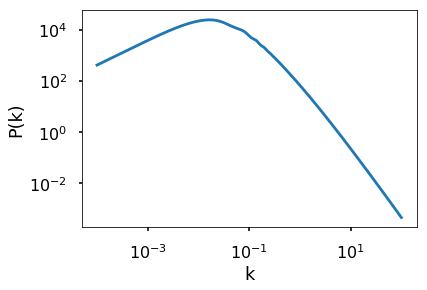

In [2]:
# Generating the power spectrum

k = np.logspace(-4, 2, 1000)
p = EHPower(Planck15, redshift=0.0)(k)
np.savetxt('powerspec.txt', np.array((k, p)).T)

plt.plot(k, p)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('k')
plt.ylabel('P(k)')

In the next cell we write the configuration file for FastPM, where we define the resolution of the box ($128^3$ for simplicity) and the size of the box ($10\;h^{-1}\mathrm{Mpc}$). The size of the box is quite small compared to what is usually used in the literature. However, it will allow us to resolve the filaments, and I believe it is better for the visualization.

In [62]:
N       = 128
boxsize = 10.0 # Mpc/h
a_list  = [0.0909,0.1000,0.1111,0.1250,0.1429]

In [3]:
%%file nbodykit.lua

nc = 128
boxsize = 10.0

time_step = linspace(0.01, 0.15, 10)

output_redshifts= {6.0,7.0,8.0,9.0,10.0,50.}  -- redshifts of output

omega_m = 0.307494
h       = 0.6774

read_powerspectrum= "powerspec.txt"
-- read_grafic_gaussian= "test.high.ref.amps" 
random_seed= 100

pm_nc_factor = 2

np_alloc_factor= 4.0      -- Amount of memory allocated for particle

write_snapshot= "fastpm" 
write_nonlineark= "fastpm" 

-- 1d power spectrum (raw), without shotnoise correction
write_powerspectrum = "powerspec-debug"

Overwriting nbodykit.lua


Next cell is actually runs the simulation. It may take some time (order of minutes for N=128) to complete.

In [4]:
%%bash
export OMP_NUM_THREADS=1
mpirun -n 4 fastpm nbodykit.lua

[ 0000000.0000 ]: This is FastPM, with libfastpm version 1.0.8442714069.
[ 0000000.0050 ]: Configuration {
	boxsize = 10.0,
	compute_potential = false,
	dealiasing_type = "none",
	dh_factor = 1.0,
	enforce_broadband_kmax = 4,
	f_nl_type = "none",
	force_mode = "fastpm",
	h = 0.677400000000000002,
	inverted_ic = false,
	kernel_type = "3_4",
	kmax_primordial_over_knyquist = 0.25,
	nc = 128,
	np_alloc_factor = 4.0,
	omega_m = 0.30749399999999999,
	painter_support = 2,
	painter_type = "cic",
	pm_nc_factor = 2,
	random_seed = 100,
	read_powerspectrum = "powerspec.txt",
	remove_cosmic_variance = false,
	set_mode_method = "override",
	shift = false,
	sigma8 = 0,
	write_nonlineark = "fastpm",
	write_powerspectrum = "powerspec-debug",
	write_snapshot = "fastpm",
	za = false,
	aout = {
		0.142857142857142849,
		0.125,
		0.111111111111111105,
		0.100000000000000006,
		0.090909090909090912,
		0.019607843137254902,
	},
	output_redshifts = {
		6.0,
		7.0,
		8.0,
		9.0,
		10.0,
		50.0,
	},
	time_step

We can check the folder and see whether snapshots were generated.

In [5]:
ls

00-Start-Here.ipynb         powerspec-debug_0.1900.txt
01-Preparation.ipynb        powerspec-debug_0.2080.txt
fastpm_0.0196/              powerspec-debug_0.2800.txt
fastpm_0.0909/              powerspec-debug_0.3070.txt
fastpm_0.1000/              powerspec-debug_0.3700.txt
fastpm_0.1111/              powerspec-debug_0.4060.txt
fastpm_0.1250/              powerspec-debug_0.4600.txt
fastpm_0.1429/              powerspec-debug_0.5050.txt
fof.py                      powerspec-debug_0.5500.txt
nbodykit.lua                powerspec-debug_0.6040.txt
None0000000.png             powerspec-debug_0.6400.txt
powerspec-debug_0.0100.txt  powerspec-debug_0.7030.txt
powerspec-debug_0.0240.txt  powerspec-debug_0.7300.txt
powerspec-debug_0.0380.txt  powerspec-debug_0.8020.txt
powerspec-debug_0.0520.txt  powerspec-debug_0.8200.txt
powerspec-debug_0.0660.txt  powerspec-debug_0.9010.txt
powerspec-debug_0.0800.txt  powerspec-debug_0.9100.txt
powerspec-debug_0.0940.txt  powerspec-debug_1.0000.txt
powerspec-

/home/kaurov/anaconda3/envs/cfastpm/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


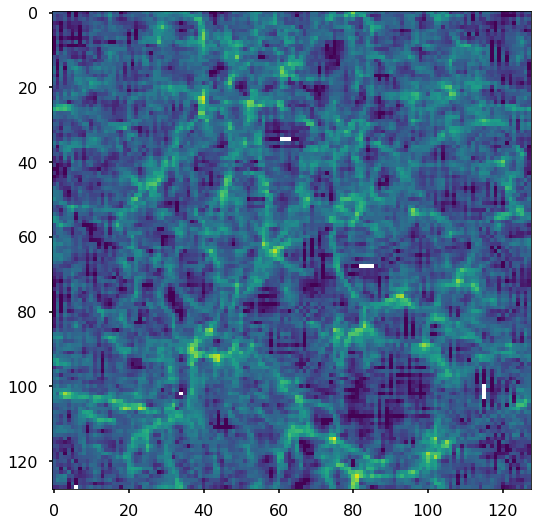

In [51]:
part = BigFileCatalog('fastpm_0.1250', dataset='1/', header='Header')

q = part.to_mesh(Nmesh=N, compensated=True)
q = q.to_field()

plt.imshow(np.log10(q[0,:,:]),vmin=-1)

The next cell should run the halo finder directly from the notebook for each redshift snapshot.

In [25]:
for a in a_list:
    print('a = ', a)
    
    ns = {'fpm': 'fastpm_%1.4f'%a,
         'with_peak': True,
         'nmin': 20,
         'fof': 'fastpm_%1.4f/fof'%a,
         'll': 0.2}

    cat = BigFileCatalog(ns['fpm'], header='Header', dataset='1/')

    cat.attrs['BoxSize']  = np.ones(3) * cat.attrs['BoxSize'][0]
    cat.attrs['Nmesh']  = np.ones(3) * cat.attrs['NC'][0]

    cosmo = Planck15.match(Omega0_m=cat.attrs['OmegaM'])

    M0 = cat.attrs['OmegaM'][0] * 27.75 * 1e10 * cat.attrs['BoxSize'].prod() / cat.csize

    if cat.comm.rank == 0:
        print('BoxSize', cat.attrs['BoxSize'])
        print('Nmesh', cat.attrs['Nmesh'])
        print('Mass of a particle', M0)
        print('OmegaM', cosmo.Om0)


    if ns['with_peak']:
        cat['Density'] = KDDensity(cat).density

    fof = FOF(cat, linking_length=ns['ll'], nmin=ns['nmin'])

    if ns['with_peak']:
        features = fof.find_features(peakcolumn='Density')
    else:
        features = fof.find_features(peakcolumn=None)

    features['Mass'] = M0 * features['Length']
    if fof.comm.rank == 0:
        print('Total number of features found', features.csize)
        print('Saving columns', features.columns)

    features.save(ns['fof'] + '/%0.3f' % ns['ll'], features.columns)

BoxSize [10. 10. 10.]
Nmesh [128. 128. 128.]
Mass of a particle 40688316.822052
OmegaM 0.3074940000000001
Total number of features found 177
Saving columns ['CMPosition', 'CMVelocity', 'Length', 'Mass', 'PeakPosition', 'PeakVelocity', 'Selection', 'Value', 'Weight']
BoxSize [10. 10. 10.]
Nmesh [128. 128. 128.]
Mass of a particle 40688316.822052
OmegaM 0.3074940000000001
Total number of features found 526
Saving columns ['CMPosition', 'CMVelocity', 'Length', 'Mass', 'PeakPosition', 'PeakVelocity', 'Selection', 'Value', 'Weight']
BoxSize [10. 10. 10.]
Nmesh [128. 128. 128.]
Mass of a particle 40688316.822052
OmegaM 0.3074940000000001
Total number of features found 1004
Saving columns ['CMPosition', 'CMVelocity', 'Length', 'Mass', 'PeakPosition', 'PeakVelocity', 'Selection', 'Value', 'Weight']
BoxSize [10. 10. 10.]
Nmesh [128. 128. 128.]
Mass of a particle 40688316.822052
OmegaM 0.3074940000000001
Total number of features found 1454
Saving columns ['CMPosition', 'CMVelocity', 'Length', 'M

In [59]:
# convert to a MeshSource, using TSC interpolation on 256^3 mesh
part = BigFileCatalog('fastpm_0.1250', dataset='1/', header='Header')
mesh = part.to_mesh(Nmesh=N, compensated=True)

r = FFTPower(mesh, mode='1d', dk=0.05, kmin=2*np.pi/boxsize)

Pk = r.power

In [60]:
# Pk['k']
# Pk['power']

Text(0,0.5,'$P(k)$ [$h^{-3}\\mathrm{Mpc}^3$]')

/home/kaurov/anaconda3/envs/cfastpm/lib/python3.5/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


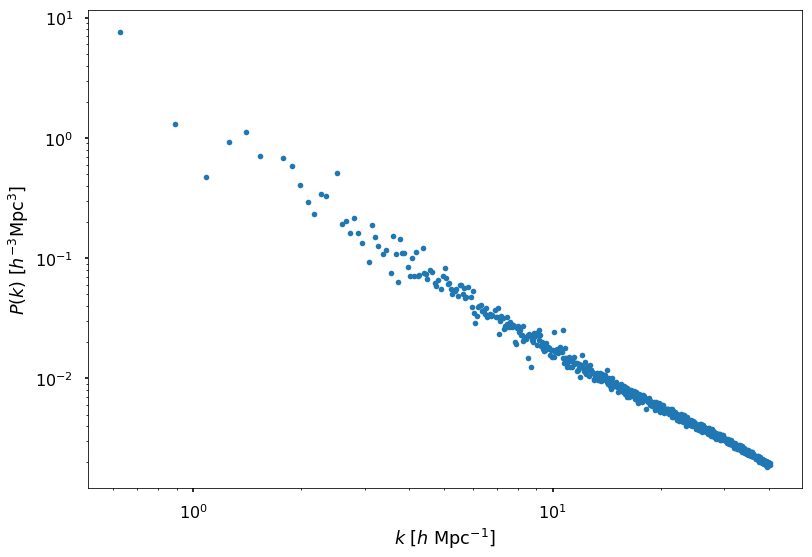

In [61]:

# print the shot noise subtracted P(k)
plt.loglog(Pk['k'], Pk['power'].real, '.')

# format the axes
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$ [$h^{-3}\mathrm{Mpc}^3$]")
# plt.xlim(0.01, 0.6)

____

# Smoothing

Now we show how a field can be smoothed (convolved) with various kernels. One can simply use numpy functions. However, we construct them ourselves to have a bit more control.

In [63]:
def sph_filter(r, N, mode, f = lambda x, y: x**2+y):
    ''' Constructs spherical filter
    Args:
      r:     parameter
      N:     size of the grid
      mode:  
      f:     function, i.e. (f = lambda x, y: x**2+y)
    '''
    x,y,z = np.mgrid[:N,:N,:N]
    x[x>N/2] = N - x[x>N/2]
    y[y>N/2] = N - y[y>N/2]
    z[z>N/2] = N - z[z>N/2]
    r2 = (x**2+y**2+z**2)
    if mode == 'tophat':
        temp = r2<r**2
    elif mode == 'gaussian':
        temp = np.exp(-0.5*(r2/r**2))
    elif mode == 'r^-2':
        temp = 1/(r2+r)
    elif mode == 'custom':
        temp = f(np.sqrt(r2), r)
    return temp / np.sum(temp)

def ft_sph_filter(r, N, mode, f = lambda x, y: x**2+y):
    return np.fft.rfftn(sph_filter(r, N, mode, f))

def smooth(ft_data, r, N, mode, data_in_fourier_space = True, f = lambda x, y: x**2+y):
    """
    
    By default data is already in Fourier space
    """
    if data_in_fourier_space:
        return np.fft.irfftn(ft_sph_filter(r, N, mode, f) * ft_data)
    else:
        return np.fft.irfftn(ft_sph_filter(r, N, mode, f) * np.rfftn(ft_data))
        

/home/kaurov/anaconda3/envs/cfastpm/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


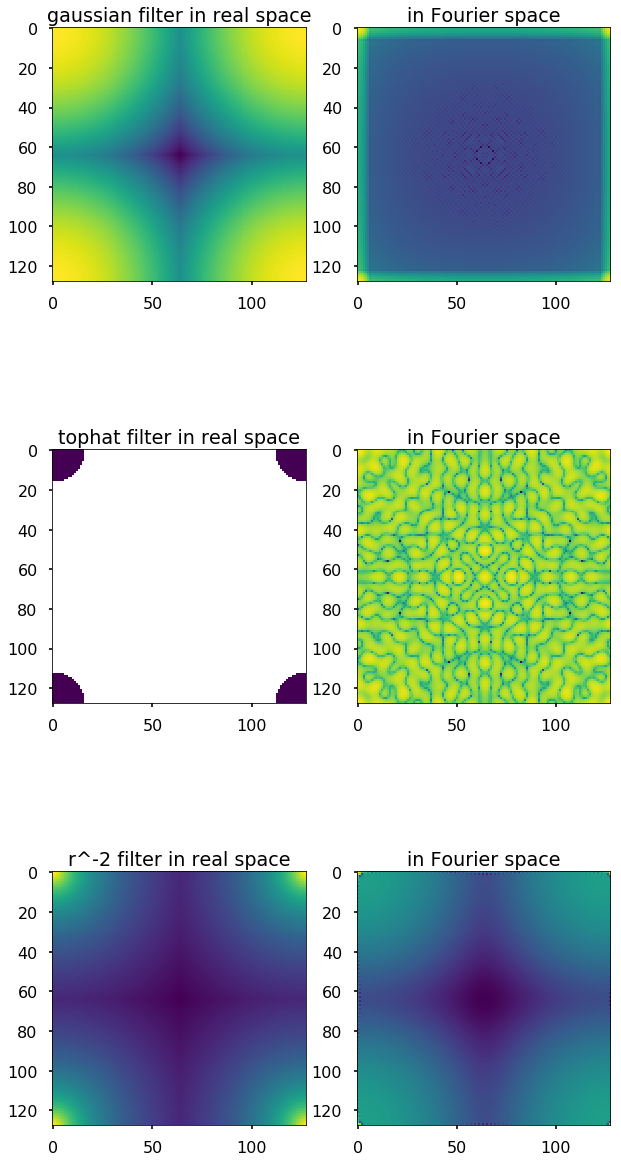

In [64]:
plt.figure(figsize=(10,22))
for i, filt in enumerate(['gaussian', 'tophat', 'r^-2']):
    plt.subplot(3,2,2*i+1)
    plt.imshow(np.log10(sph_filter(16,N,filt))[:,:,0])
    plt.title(filt + ' filter in real space')
    plt.subplot(3,2,2*i+2)
    plt.imshow(np.log10(np.abs(ft_sph_filter(16,N,filt)[:,:,64])))
    plt.title('in Fourier space')
# print(np.abs(ft_sph_filter(50,N,'gaussian')[:,:,64]))

On the real data smoothing looks like this:

In [65]:
part = BigFileCatalog('fastpm_0.0196', dataset='1/', header='Header')
ic = part.to_mesh(Nmesh=N).to_field()
ic = np.array(ic)

In [66]:
f_ic = np.fft.rfftn(ic)

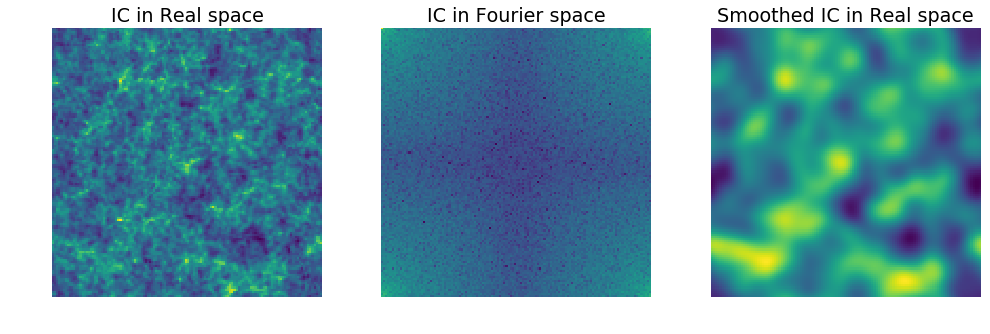

In [67]:
plt.figure(figsize=(14,6))
plt.subplot(131)
plt.imshow(ic[0,:,:])
plt.axis('off')
plt.title('IC in Real space')
plt.subplot(132)
plt.imshow(np.log10(np.abs(f_ic[:,:,0])))
plt.axis('off')
plt.title('IC in Fourier space')
plt.subplot(133)
plt.imshow(smooth(f_ic, 4, 128, 'gaussian')[0,:,:])
plt.axis('off')
plt.title('Smoothed IC in Real space')

plt.tight_layout()